# Waarom vectoren, matrices en tensors?
Oorspronkelijk werden vectoren in de meetkunde en de mechanica geïntroduceerd om grootheden voor te stellen die zowel een grootte als een richting hebben, zoals verplaatsingen, krachten, versnelling, enz.
In dezelfde context werden matrices gebruikt om lineaire transformaties tussen vector-ruimtes voor te stellen.
**In Machine Learning worden vectoren, matrices en tensors veel algemener gebruikt als _containers_ voor data en model parameters** omwille van:
- computationele efficiëntie
- speciale tensors en tensor-operaties (bv. rotatie-matrices, convolutionele filters, decompositie, enz.)
- compacte notatie

## Toepassingen[^NotExhaustive]
[^NotExhaustive]: Dit zijn voorbeelden, dus niet als een exhaustieve lijst te beschouwen.
### Feature matrix voor tabulaire data
In veel gevallen vertrekken we van data in een **tabulair formaat** (denk aan een Excel sheet) waarbij iedere cel voor een bepaalde meting staat bij een bepaald item. Verschillende metingen komen overeen met verschillende kolommen en verschillende items met verschillende rijen.

In [12]:
import os

import kagglehub
import pandas as pd

In [13]:
# Download data
path = kagglehub.dataset_download("yashdevladdha/uber-ride-analytics-dashboard")

# Load data into Pandas DataFrame
csv_file = os.path.join(path, "ncr_ride_bookings.csv")
df = pd.read_csv(csv_file)
print("✅ Data loaded successfully!")

✅ Data loaded successfully!



Machine Learning is een zaak van wiskunde en daarom moet alle informatie waarin we patronen willen herkennen vertaald worden naar numerieke waarden. Bij tabulaire data hebben we doorgaans te maken met heel verschillende data-types. Voor sommige data types is de vertaling in numerieke waarden evident, zoals temperatuur of aandelenkoersen, maar in andere gevallen zijn er speciale voorbereidingen nodig. **De manier waarop we informatie vertalen naar numerieke waarden bepaalt heel sterk welke patronen we al dan _niet_ kunnen oppikken met het ML model**. Het is onder andere belangrijk om rekening te houden met volgende aspecten:
- **Meetschaal**:
    - **Nominaal**: De informatie laat toe om items in bepaalde categorieën te plaatsen (bv. "fruit" $\neq$ "groente" $\neq$ "vlees" $\neq$ "rond" $\neq$ "vierkant" $\neq$ $\ldots$)
    - **Ordinaal**: De informatie laat toe om items te ordenen (bv. "small" $<$ "medium" $<$ "large")
    - **Interval**: De informatie laat toe om de afstand tussen items te bepalen (bv. $45\degree - 10\degree = 5\degree - (-30\degree)$)
    - **Ratio**: De informatie laat toe om de verhoudingen tussen items te bepalen (bv. $\frac{120km/h}{60km/h} = \frac{30km/h}{15km/h}$)

:::{note} Nominale waarden
Om nominale waarden om te zetten in numerieke waarden wordt vaak zogenaame **_one-hot encoding_** toegepast. Daarbij wordt iedere waarde omgezet in een binaire vector met evenveel dimensies als er _levels_ zijn in de nominale schaal.
:::

$$
\begin{pmatrix}
fruit \cr
fruit  \cr
groente \cr
vlees \cr
\vdots  \cr
\end{pmatrix} \rarr \begin{bmatrix}
1 & 0 & 0 \cr
1 & 0 & 0 \cr
0 & 1 & 0 \cr
0 & 0 & 1 \cr
\vdots  \cr
\end{bmatrix}
$$

- **Niet-lineariteit**:
    Op een interval of ratio schaal kunnen we aan de hand van niet lineaire tranformaties hetzelfde interval een ander gewicht geven naargelang de positie op de schaal. Voorbeelden zijn logarithmische transformatie, exponentiële transformatie en polynomiale transformatie.
:::{note} 🌍 Likes
:icon: false
:class: simple
Als je bijvoorbeeld een model wil maken dat verkoopscijfers voorspelt op basis van likes bij social-media marketing, zou je ervoor kunnen kiezen om een lineair regressie model te bouwen om de lineaire samenhang uit te drukken (te kwantificeren). In dit geval ga je echter de assumptie inbouwen dat het verschil tussen 1 of 2 likes hetzelfde is als tussen 100 000 en 200 000. In dat geval kan het zijn dat de linaire samenhang veel beter te vatten is door het aantal likes logarithmisch uit te drukken. 
:::

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

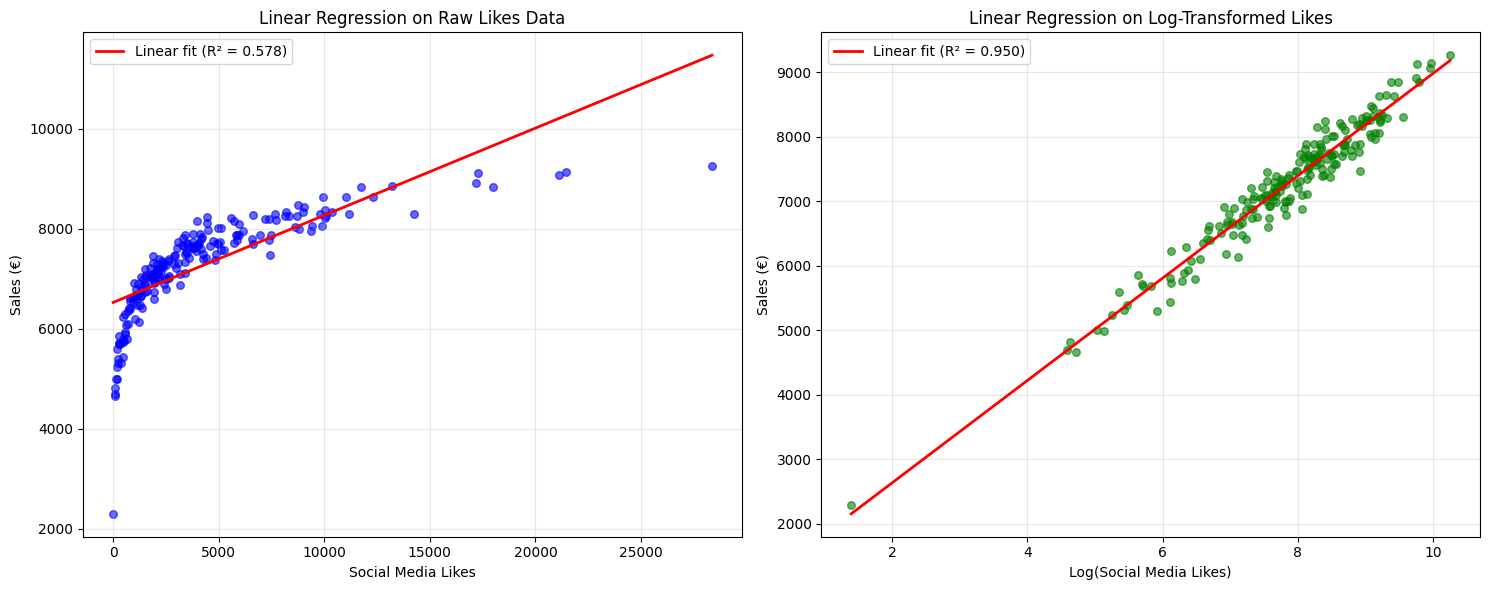


📊 Regression Results:
Raw likes model R² score: 0.578
Log-transformed likes model R² score: 0.950

🎯 Improvement with log transformation: 64.2%

📈 Discovered relationship:
Sales ≈ 1051 + 793 × log(likes)


In [15]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# Generate synthetic data: social media likes vs sales
# Create likes data with exponential distribution (more realistic)
n_samples = 200
likes_raw = rng.exponential(scale=5000, size=n_samples)
likes_raw = np.clip(likes_raw, 1, 500000)  # Clip to reasonable range

# Generate sales data with logarithmic relationship to likes + noise
# Sales = base_sales + log_coefficient * log(likes) + noise
base_sales = 1000
log_coefficient = 800
noise_std = 200
sales = base_sales + log_coefficient * np.log(likes_raw) + rng.normal(0, noise_std, n_samples)
sales = np.clip(sales, 0, None)  # Ensure non-negative sales

# Sort data for better visualization
sort_idx = np.argsort(likes_raw)
likes_sorted = likes_raw[sort_idx]
sales_sorted = sales[sort_idx]

# Prepare data for regression
X_raw = likes_sorted.reshape(-1, 1)
X_log = np.log(likes_sorted).reshape(-1, 1)
y = sales_sorted

# Fit linear regression models
model_raw = LinearRegression().fit(X_raw, y)
model_log = LinearRegression().fit(X_log, y)

# Make predictions
y_pred_raw = model_raw.predict(X_raw)
y_pred_log = model_log.predict(X_log)

# Calculate R² scores
r2_raw = r2_score(y, y_pred_raw)
r2_log = r2_score(y, y_pred_log)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Raw likes vs sales with linear regression
ax1.scatter(likes_sorted, sales_sorted, alpha=0.6, color="blue", s=30)
ax1.plot(
    likes_sorted, y_pred_raw, color="red", linewidth=2, label=f"Linear fit (R² = {r2_raw:.3f})"
)
ax1.set_xlabel("Social Media Likes")
ax1.set_ylabel("Sales (€)")
ax1.set_title("Linear Regression on Raw Likes Data")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Log-transformed likes vs sales with linear regression
ax2.scatter(np.log(likes_sorted), sales_sorted, alpha=0.6, color="green", s=30)
ax2.plot(
    np.log(likes_sorted),
    y_pred_log,
    color="red",
    linewidth=2,
    label=f"Linear fit (R² = {r2_log:.3f})",
)
ax2.set_xlabel("Log(Social Media Likes)")
ax2.set_ylabel("Sales (€)")
ax2.set_title("Linear Regression on Log-Transformed Likes")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results
print("\n📊 Regression Results:")
print(f"Raw likes model R² score: {r2_raw:.3f}")
print(f"Log-transformed likes model R² score: {r2_log:.3f}")
print(f"\n🎯 Improvement with log transformation: {((r2_log - r2_raw) / r2_raw * 100):.1f}%")

# Show the mathematical relationship
print("\n📈 Discovered relationship:")
print(f"Sales ≈ {model_log.intercept_:.0f} + {model_log.coef_[0]:.0f} × log(likes)")


- **Cyclische informatie**:
    Bij bepaalde schalen is er cycliciteit. Denk bijvoorbeeld aan de seizoenen ("winter" < "lente" < "zomer" < "herfst" < "winter" < ...) of dagen van de week ("zondag" < "maandag", "dinsdag", "woensdag", "donderdag", "vrijdag", "zaterdag", "zondag", "maandag", ...). Als we deze informatie zomaar vertalen naar numerieke waarden (bv. $[0, 1, 2, 3, 4, 5, 6, 0, 1, ...]^T$) maaken we een fout door bijvoorbeeld te stellen dat het verschil tussen "zaterdag" en "zondag" 6 is en tussen "zondag" en "maandag" 1 of dat "zaterdag" $>$ "zondag" en "zondag" $<$ "maandag".

🚫 Naive encoding of days:
  Sunday: 0
  Monday: 1
  Tuesday: 2
  Wednesday: 3
  Thursday: 4
  Friday: 5
  Saturday: 6

❌ Problems with naive encoding:
  Distance Saturday → Sunday: 6 (should be 1!)
  Distance Sunday → Monday: 1 (correct)
  Distance Friday → Saturday: 1 (correct)

✅ Cyclic encoding using trigonometric functions:
  Sunday: (1.000, 0.000)
  Monday: (0.623, 0.782)
  Tuesday: (-0.223, 0.975)
  Wednesday: (-0.901, 0.434)
  Thursday: (-0.901, -0.434)
  Friday: (-0.223, -0.975)
  Saturday: (0.623, -0.782)

✅ Distances with cyclic encoding (all should be similar):
  Distance Saturday → Sunday: 0.868
  Distance Sunday → Monday: 0.868
  Distance Friday → Saturday: 0.868


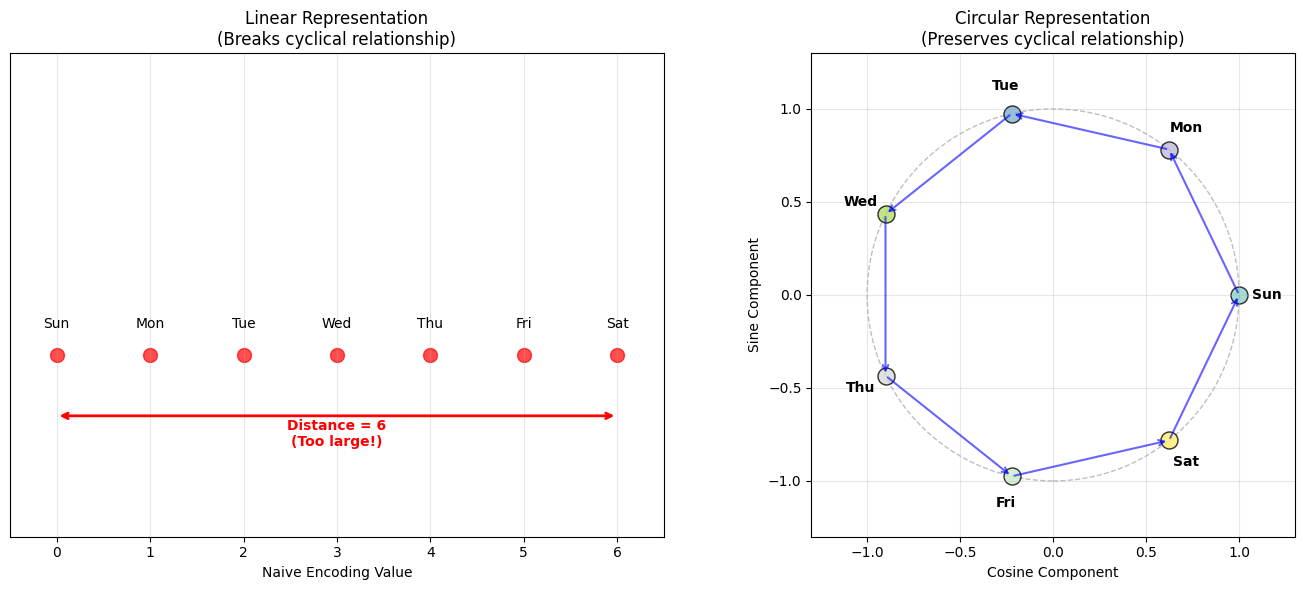

In [16]:
# Define days of the week
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
n_days = len(days)

# Problem: Naive numerical encoding
naive_encoding = np.arange(n_days)  # [0, 1, 2, 3, 4, 5, 6]
print("🚫 Naive encoding of days:")
for i, day in enumerate(days):
    print(f"  {day}: {naive_encoding[i]}")

# Calculate distances between consecutive days using naive encoding
print("\n❌ Problems with naive encoding:")
print(f"  Distance Saturday → Sunday: {abs(naive_encoding[6] - naive_encoding[0])} (should be 1!)")
print(f"  Distance Sunday → Monday: {abs(naive_encoding[0] - naive_encoding[1])} (correct)")
print(f"  Distance Friday → Saturday: {abs(naive_encoding[5] - naive_encoding[6])} (correct)")

# Solution: Cyclic encoding using trigonometric functions
angles = 2 * np.pi * naive_encoding / n_days  # Convert to angles (0 to 2π)
cyclic_x = np.cos(angles)  # X-coordinate on unit circle
cyclic_y = np.sin(angles)  # Y-coordinate on unit circle

print("\n✅ Cyclic encoding using trigonometric functions:")
for i, day in enumerate(days):
    print(f"  {day}: ({cyclic_x[i]:.3f}, {cyclic_y[i]:.3f})")


# Calculate Euclidean distances between consecutive days using cyclic encoding
def euclidean_distance(p1, p2):
    """
    Calculate the Euclidean distance between two 2D points.

    Parameters
    ----------
    p1 (tuple): First point as (x, y) coordinates
    p2 (tuple): Second point as (x, y) coordinates

    Returns
    -------
    float: The Euclidean distance between the two points
    """
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)


print("\n✅ Distances with cyclic encoding (all should be similar):")
sat_coords = (cyclic_x[6], cyclic_y[6])
sun_coords = (cyclic_x[0], cyclic_y[0])
mon_coords = (cyclic_x[1], cyclic_y[1])
fri_coords = (cyclic_x[5], cyclic_y[5])

print(f"  Distance Saturday → Sunday: {euclidean_distance(sat_coords, sun_coords):.3f}")
print(f"  Distance Sunday → Monday: {euclidean_distance(sun_coords, mon_coords):.3f}")
print(f"  Distance Friday → Saturday: {euclidean_distance(fri_coords, sat_coords):.3f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Linear representation (naive encoding)
ax1.scatter(naive_encoding, np.zeros_like(naive_encoding), s=100, c="red", alpha=0.7)
for i, day in enumerate(days):
    ax1.annotate(
        day[:3],
        (naive_encoding[i], 0),
        xytext=(0, 20),
        textcoords="offset points",
        ha="center",
        fontsize=10,
    )

# Highlight the problem: Saturday to Sunday distance
ax1.annotate(
    "", xy=(0, -0.1), xytext=(6, -0.1), arrowprops={"arrowstyle": "<->", "color": "red", "lw": 2}
)
ax1.text(3, -0.15, "Distance = 6\n(Too large!)", ha="center", color="red", fontweight="bold")

ax1.set_xlim(-0.5, 6.5)
ax1.set_ylim(-0.3, 0.5)
ax1.set_xlabel("Naive Encoding Value")
ax1.set_title("Linear Representation\n(Breaks cyclical relationship)")
ax1.grid(True, alpha=0.3)
ax1.set_yticks([])

# Plot 2: Circular representation (cyclic encoding)
circle = plt.Circle((0, 0), 1, fill=False, color="gray", linestyle="--", alpha=0.5)
ax2.add_patch(circle)

# Plot days on the circle
colors = plt.cm.Set3(np.linspace(0, 1, n_days))
for i, day in enumerate(days):
    ax2.scatter(cyclic_x[i], cyclic_y[i], s=150, c=[colors[i]], alpha=0.8, edgecolors="black")
    # Position labels slightly outside the circle
    label_x = cyclic_x[i] * 1.15
    label_y = cyclic_y[i] * 1.15
    ax2.annotate(
        day[:3], (label_x, label_y), ha="center", va="center", fontsize=10, fontweight="bold"
    )

# Draw arrows to show cyclical nature
for i in range(n_days):
    next_i = (i + 1) % n_days
    ax2.annotate(
        "",
        xy=(cyclic_x[next_i], cyclic_y[next_i]),
        xytext=(cyclic_x[i], cyclic_y[i]),
        arrowprops={"arrowstyle": "->", "color": "blue", "alpha": 0.6, "lw": 1.5},
    )

ax2.set_xlim(-1.3, 1.3)
ax2.set_ylim(-1.3, 1.3)
ax2.set_aspect("equal")
ax2.set_xlabel("Cosine Component")
ax2.set_ylabel("Sine Component")
ax2.set_title("Circular Representation\n(Preserves cyclical relationship)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- **_Missing_ data**:
    In veel tabulaire data sets kan niet voor ieder item steeds de volledige reeks observaties gemaakt worden (denk bijvoobeeld aan een temperatuursensor die een fout geeft). In sommige gevallen kunnen machine learning algorithmes daar perfect mee om (bv. Decision trees, Kalman Filters), maar veel algorithmes verwachten volledige input. Soms kan beslist worden om alle rijen te verwijderen waarvoor er een of meedere _missing values_ zijn - als daardoor nog genoeg data overblijft voor het leeralgorithme. Er van ook beslist worden om die _missing values_ op een zinvolle manier in te vullen (bv. door het gemiddelde van alle observaties). In dat geval spreekt men over **_missing value imputation_**.

Eens we de informatie waarin we patroonhekenning willen doen vertaald hebben naar numerieke waarden, verzamelen we ze in een _feature matrix/tensor_ met items in de rijen en verschillende features in de kolommen.

### Data translatie, schaling, reflectie en rotatie
We zullen zien dat er veel toepassingen zijn waar data op een bepaald moment getransformeerd worden via **translatie**, **schaling**, **reflectie** en/of **rotatie**. Dit is zeer transparant en efficient in computationele zin als we data uitdrukken als tensors:
- **Translatie**: De data wordt uitgedrukt (of gekwantificeerd) ten opzichte van een ander nulpunt in de ruimte. We kunnen anderszijds ook zeggen dat de data wordt **_verschoven_** in de ruimte. In het geval van een input matrix met $m$ data punten in $n$ dimensies krijgen we:
$$
\pmb{X}' = (\pmb{X}^T + \pmb{c})^T 
$$
met $\pmb{X}^{m \times n}$ en $\pmb{c}^n$
- **Schaling**: De data worden uitgedrukt ten opzichte van een andere schaal op één of meerdere assen in de ruimte (of: de data wordt **_uitgerokken_**).
$$
\pmb{X}' = (\pmb{X}^T*\pmb{s})^T 
$$
- **Reflectie**[^reflection]: De data wordt gespiegeld ten opzichte van één of meerdere assen in de ruimte.
$$
\pmb{X}' = (\pmb{X}^T*\pmb{r})^T 
$$
met $\pmb{r} \isin \{-1, 1\}$
[^reflection]: Merk op dat reflectie een speciaal geval is van schaling
- **Rotatie**: De data worden uitgedrukt ten opzichte van een ander orthogonaal assenstelsel in de ruimte, met dezelfde oorsprong.
$$
\pmb{X}' = \pmb{X}*\pmb{R}
$$
met $\pmb{R}$ een $n \times n$ orthogonale rotatie-matrix

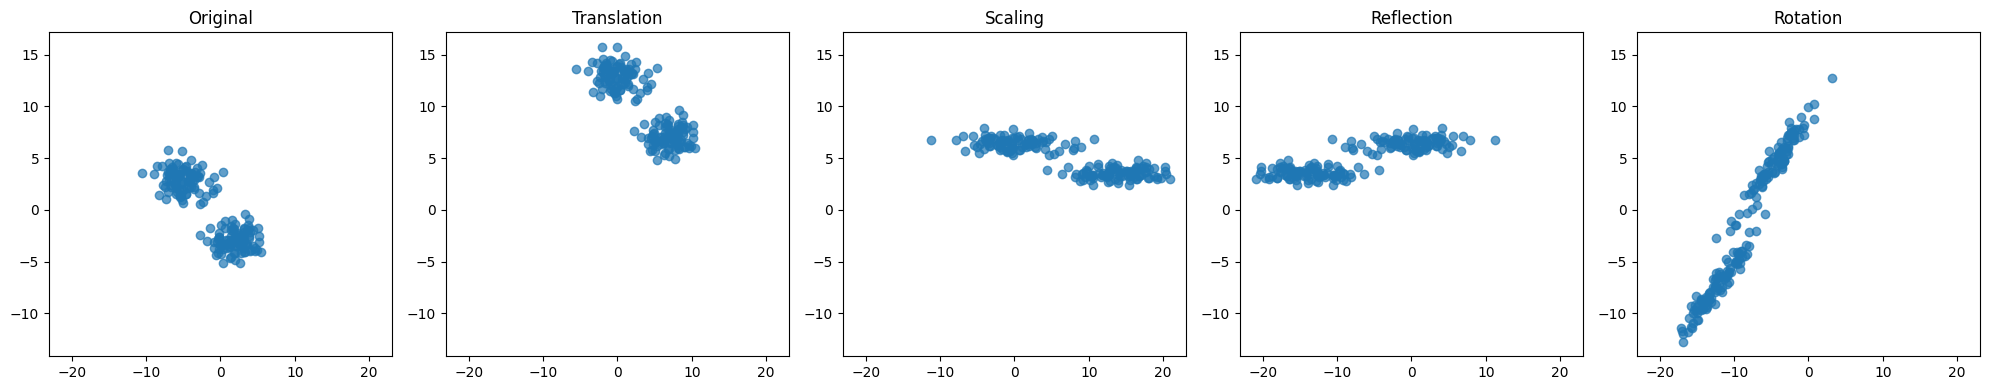

In [22]:
# Generate 100 2D Gaussian datapoints
mean1 = [2, -3]
mean2 = [-5, 3]
cov = [[3, 0], [0, 1]]  # Different std deviations for x and y
X = np.vstack([rng.multivariate_normal(mean1, cov, 100), rng.multivariate_normal(mean2, cov, 100)])

# Define transformations
# Translation
c = np.array([5, 10])
T = X + c
# Scaling
s = np.array([2, 0.5])
S = T * s
# Reflection across y-axis
R = S * np.array([-1, 1])
# Rotation by 45 degrees
theta = np.radians(45)
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
D = R @ rotation_matrix.T

# Plot original and transformed data
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
titles = ["Original", "Translation", "Scaling", "Reflection", "Rotation"]
datasets = [X, T, S, R, D]

# Calculate global axis limits to keep ranges constant
all_data = np.concatenate(datasets, axis=0)
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

# Add some padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

for ax, data, title in zip(axs, datasets, titles, strict=False):
    ax.scatter(data[:, 0], data[:, 1], alpha=0.7)
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()